# Faster processing the message table using Dask

This notebook demonstrates use of Dask dataframes to speed up handling of the roughly 32 million xdmod job-task records. Dask is faster because it loads and processes chunks of the data in parallel. To support the use of dask, we have converted the xdmod table into [`parquet`](https://parquet.apache.org/) files in the directory `
/project/rcde/xdmod_analysis/jobs_with_hosts_parquet`. Parquet is just an efficient storage format for tabular data. I have broken the data into many small parquet files because this allows dask to perform many reads in parallel. 

The Dask dataframe API attempts to copy the pandas API as closely as possible. 

In [1]:
import pandas as pd
import dask.dataframe as dd
import os, shutil
import logging
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
ddf = dd.read_parquet('/project/rcde/xdmod_analysis/jobs_with_hosts_dialy_time/')

In [4]:
df_nodes = pd.read_csv('/project/rcde/xdmod_analysis/host_info.csv')

In [5]:
df_nodes[df_nodes.phase=='29'].T

,1637,1666,1678,1684,1685,1688,1691,1695,1696,1698,...,1719,1720,1721,1722,1723,1725,1726,1727,1729,1730
hostname,node0384,node0386,node0382,node0388,node0385,node0389,node0397,node0391,node0395,node0392,...,node0414,node0416,node0411,node0408,node0410,node0412,node0407,node0415,node0418,node0390
Mom,node0384.palmetto.clemson.edu,node0386.palmetto.clemson.edu,node0382.palmetto.clemson.edu,node0388.palmetto.clemson.edu,node0385.palmetto.clemson.edu,node0389.palmetto.clemson.edu,node0397.palmetto.clemson.edu,node0391.palmetto.clemson.edu,node0395.palmetto.clemson.edu,node0392.palmetto.clemson.edu,...,node0414.palmetto.clemson.edu,node0416.palmetto.clemson.edu,node0411.palmetto.clemson.edu,node0408.palmetto.clemson.edu,node0410.palmetto.clemson.edu,node0412.palmetto.clemson.edu,node0407.palmetto.clemson.edu,node0415.palmetto.clemson.edu,node0418.palmetto.clemson.edu,node0390.palmetto.clemson.edu
ntype,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS,...,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS,PBS
pcpus,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
Priority,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
sharing,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,...,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared,default_shared
comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arch,linux,linux,linux,linux,linux,linux,linux,linux,linux,linux,...,linux,linux,linux,linux,linux,linux,linux,linux,linux,linux
chip_manufacturer,intel,intel,intel,intel,intel,intel,intel,intel,intel,intel,...,intel,intel,intel,intel,intel,intel,intel,intel,intel,intel
chip_model,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon,...,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon,xeon


In [6]:
df_nodes.columns

Index(['hostname', 'Mom', 'ntype', 'pcpus', 'Priority', 'sharing', 'comment',
       'arch', 'chip_manufacturer', 'chip_model', 'chip_type', 'host', 'hpmem',
       'interconnect', 'make', 'manufacturer', 'mem', 'model', 'ncpus',
       'ngpus', 'node_make', 'node_manufacturer', 'node_model', 'phase',
       'qcat', 'ssd', 'vmem', 'vnode', 'vntype', 'gpu_model',
       'accelerator_memory', 'hbmem', 'naccelerators'],
      dtype='object')

# Cleaning

In [10]:
# derived measures
ddf['cpus_per_node'] = ddf.processor_count/ddf.node_count
ddf['gpus_per_node'] = ddf.gpu_count/ddf.node_count
ddf['cpu_hours'] = ddf['cpus_per_node'] * ddf['seconds'] / 3600
ddf['gpu_hours'] = ddf['gpus_per_node'] * ddf['seconds'] / 3600

ddf['date'] = dd.to_datetime(ddf['date'])

In [11]:
# cpu/gpu capacity daily caps
df_nodes['daily_cpu_hours'] = df_nodes['ncpus']*24
df_nodes['daily_gpu_hours'] = df_nodes['ngpus']*24

## Get host-day level data

In [20]:
# compute hours through time
ddf['year'] = ddf.date.dt.year
ddf['month'] = ddf.date.dt.month
ddf['day'] = ddf.date.dt.day

df_t = ddf.\
    query("submit_time > '2020-01-01 00:00:00'").\
    groupby(['hostname', 'year', 'month', 'day'])['cpu_hours', 'gpu_hours'].\
    sum().\
    compute().\
    reset_index()

In [21]:
df_t

,hostname,year,month,day,cpu_hours,gpu_hours
0,node0001,2021,12,30,23.474444,0.0
1,node0001,2021,12,31,48.000000,0.0
2,node0001,2022,1,1,48.000000,0.0
3,node0001,2022,1,2,87.178889,0.0
4,node0001,2022,1,3,115.878056,0.0
...,...,...,...,...,...,...
2049828,skystd46,2023,6,9,1952.426667,0.0
2049829,skystd46,2023,6,10,2496.000000,0.0
2049830,skystd46,2023,6,11,2135.271111,0.0
2049831,skystd46,2023,6,12,2192.925000,0.0


In [22]:
df_t['date'] = pd.to_datetime(df_t.apply(lambda x: f"{x.year}-{x.month}-{x.day}", axis=1))
df_t = df_t.sort_values('date')

In [16]:
df_t

,hostname,start_year,start_month,start_day,cpu_hours,gpu_hours,date
1019244,node0967,2020,1,1,21.828889,0.0,2020-01-01
1017391,node0819,2020,1,1,27.681920,0.0,2020-01-01
1022208,node1272,2020,1,1,51.055974,0.0,2020-01-01
1017368,node0817,2020,1,1,9.140123,0.0,2020-01-01
1022217,node1273,2020,1,1,51.055974,0.0,2020-01-01
...,...,...,...,...,...,...,...
2044511,node1805,2023,6,13,27.515556,0.0,2023-06-13
2044496,node1804,2023,6,13,160.088889,0.0,2023-06-13
2044493,node1803,2023,6,13,160.088889,0.0,2023-06-13
2031264,node0028,2023,6,13,685.122222,0.0,2023-06-13


In [23]:
ddf_t = dd.from_pandas(df_t, chunksize=100000)
ddf_nodes = dd.from_pandas(df_nodes, npartitions=1)

In [24]:
ddf_host = dd.from_pandas(ddf_t.merge(ddf_nodes, on='hostname').compute(), chunksize=50000)

In [25]:
ddf_host.head()

,hostname,year,month,day,cpu_hours,gpu_hours,date,Mom,ntype,pcpus,...,ssd,vmem,vnode,vntype,gpu_model,accelerator_memory,hbmem,naccelerators,daily_cpu_hours,daily_gpu_hours
0,node0001,2021,12,30,23.474444,0.0,2021-12-30,node0001.palmetto.clemson.edu,PBS,8,...,False,32836mb,node0001,cpu_node,NaN,NaN,NaN,NaN,192,0
0,node1864,2022,4,11,390.240247,0.0,2022-04-11,node1864.palmetto.clemson.edu,PBS,24,...,False,129112mb,node1864,gpu_node,k40,NaN,NaN,NaN,576,48
0,node0970,2023,2,16,185.442222,0.0,2023-02-16,node0970.palmetto.clemson.edu,PBS,8,...,False,32848mb,node0970,cpu_node,NaN,NaN,NaN,NaN,192,0
0,node0589,2022,7,7,40.359931,0.0,2022-07-07,node0589.palmetto.clemson.edu,PBS,8,...,False,16721mb,node0589,cpu_node,NaN,NaN,NaN,NaN,192,0
0,node1850,2022,11,28,346.205556,0.0,2022-11-28,node1850.palmetto.clemson.edu,PBS,20,...,False,129506mb,node1850,gpu_node,k20,NaN,NaN,NaN,480,48


In [26]:
ddf_host.columns

Index(['hostname', 'year', 'month', 'day', 'cpu_hours', 'gpu_hours', 'date',
       'Mom', 'ntype', 'pcpus', 'Priority', 'sharing', 'comment', 'arch',
       'chip_manufacturer', 'chip_model', 'chip_type', 'host', 'hpmem',
       'interconnect', 'make', 'manufacturer', 'mem', 'model', 'ncpus',
       'ngpus', 'node_make', 'node_manufacturer', 'node_model', 'phase',
       'qcat', 'ssd', 'vmem', 'vnode', 'vntype', 'gpu_model',
       'accelerator_memory', 'hbmem', 'naccelerators', 'daily_cpu_hours',
       'daily_gpu_hours'],
      dtype='object')

## GPU-level metrics

In [28]:
df_gpu = ddf_host.groupby(['gpu_model', 'year', 'month'])['cpu_hours', 'gpu_hours', 'daily_cpu_hours', 'daily_gpu_hours'].sum()

df_gpu['cpu_percent'] = 100*df_gpu['cpu_hours'] / df_gpu['daily_cpu_hours']
df_gpu['gpu_percent'] = 100*df_gpu['gpu_hours'] / df_gpu['daily_gpu_hours']
df_gpu = df_gpu.compute().reset_index()

df_gpu['date'] = pd.to_datetime(df_gpu.apply(lambda x: f"{x.year}-{x.month}-01", axis=1))

In [30]:
n_gpu = df_gpu.gpu_model.nunique()
n_gpu

10

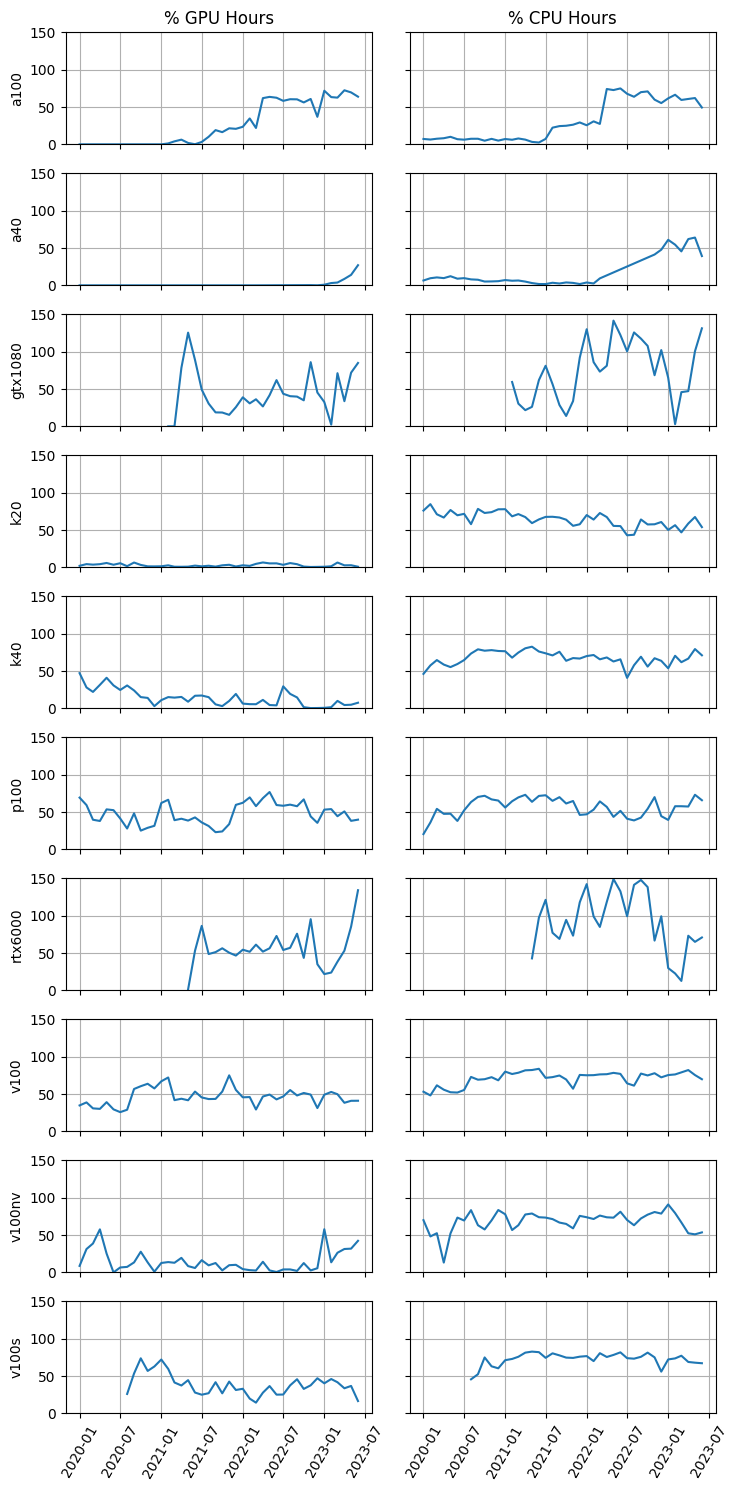

In [31]:
fig, ax = plt.subplots(nrows=10, ncols=2, sharex=True, sharey=True)
r = 1.5
fig.set_size_inches(r*5, r*10)
for ix, (g, d) in enumerate(df_gpu.groupby('gpu_model')):
    d = d.sort_values('date')
    ax[ix, 0].plot(d.date, d.gpu_percent)
    ax[ix, 1].plot(d.date, d.cpu_percent)
    ax[ix, 0].set_ylabel(g)
    ax[ix, 0].set_ylim(0,150)
    ax[ix, 0].grid()
    ax[ix, 1].grid()
    
    if ix==0:
        ax[ix, 0].set_title('% GPU Hours')
        ax[ix, 1].set_title('% CPU Hours')
        
    if ix==n_gpu-1:
        for jx in (0,1):
            ax[ix, jx].set_xticks(ticks=ax[ix,jx].get_xticks(), labels=ax[ix,jx].get_xticklabels(), rotation=60)

plt.tight_layout()

## Phase-level metrics

In [ ]:
df_ph = ddf_withhost.groupby(['phase', 'date'], as_index=False)['cpu_hours', 'gpu_hours'].sum()
df_ph

In [ ]:
n_ph = df_ph.phase.nunique()
n_ph

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=5, sharex=True)
r = 1.5
fig.set_size_inches(r*5, r*10)
ax = ax.flatten()
for ix, (g, d) in enumerate(df_ph.groupby('phase')):
    d = d.sort_values('date')
    ax[ix].plot(d.date, d.cpu_hours)
    #plt.xticks(rotation=60)
    #plt.ylabel("CPU Hours")
    #plt.grid()
    #plt.title(f"{g} nodes")
    #plt.show()

## Wait times

In [ ]:
# wait duration through time
df_t = ddf.\
    query("submit_time > '2020-01-01 00:00:00'").\
    # need to drop duplicates resulting from multiple hosts. duration is the same per host
    drop_duplicates(subset=['job_task_id', 'waitduration']).\
    groupby(['start_year', 'start_month']).\
    waitduration.mean().\
    compute().\
    reset_index()

In [ ]:
df_t

In [ ]:
df_t['date'] = pd.to_datetime(df_t.apply(lambda x: f"{int(x.start_year)}-{int(x.start_month)}", axis=1))
df_t = df_t.sort_values('date')

In [ ]:
plt.plot(df_t.date, df_t.waitduration/3600)
plt.xticks(rotation=60)
plt.ylabel("Avg. Wait (Hours)")
plt.grid()